In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.autograd.set_detect_anomaly(True)

data = pd.read_csv("/home/mw/.cache/kagglehub/datasets/yasserh/housing-prices-dataset/versions/1/Housing.csv")
data = data.dropna()

categorical_columns = data.select_dtypes(include=['object']).columns
print(categorical_columns)

for col in categorical_columns:
    if data[col].nunique() <= 2:
        data[col] = LabelEncoder().fit_transform(data[col])
    else:
        one_hot = pd.get_dummies(data[col], prefix=col)
        data = pd.concat([data.drop(col, axis=1), one_hot], axis=1)

boolean_columns = data.select_dtypes(include='bool').columns
print(boolean_columns)
data[boolean_columns] = data[boolean_columns].astype(int)
print(data.dtypes)

numeric_columns = data.select_dtypes(include=['float64']).columns
data[numeric_columns] = (data[numeric_columns] - data[numeric_columns].mean()) / data[numeric_columns].std()

data['area_standardized'] = (data['area'] - data['area'].mean()) / data['area'].std()
data['bedrooms_standardized'] = (data['bedrooms'] - data['bedrooms'].mean()) / data['bedrooms'].std()
data['bathrooms_standardized'] = (data['bathrooms'] - data['bathrooms'].mean()) / data['bathrooms'].std()
data['stories_standardized'] = (data['stories'] - data['stories'].mean()) / data['stories'].std()
data['parking_standardized'] = (data['parking'] - data['parking'].mean()) / data['parking'].std()

data = data.drop(columns=['area','bedrooms','bathrooms','stories', 'parking'])

print(data.columns)

target_column = "price"
features = data.drop(target_column, axis=1)
target = data[target_column]

print(features.head())

features_tensor = torch.tensor(features.values, dtype=torch.float32)
target_tensor = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(features_tensor, target_tensor)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea', 'furnishingstatus'],
      dtype='object')
Index(['furnishingstatus_furnished', 'furnishingstatus_semi-furnished',
       'furnishingstatus_unfurnished'],
      dtype='object')
price                              int64
area                               int64
bedrooms                           int64
bathrooms                          int64
stories                            int64
mainroad                           int64
guestroom                          int64
basement                           int64
hotwaterheating                    int64
airconditioning                    int64
parking                            int64
prefarea                           int64
furnishingstatus_furnished         int64
furnishingstatus_semi-furnished    int64
furnishingstatus_unfurnished       int64
dtype: object
Index(['price', 'mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioni

In [2]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        features = None
        for i, layer in enumerate(self.net[:-1]):
            if features is None:
                features = layer(x)
            else:
                features = layer(features)
        
        logits = torch.nn.functional.linear(features, self.net[-1].weight, self.net[-1].bias)   
        output = torch.sigmoid(logits.clone())  # Use clone() to avoid inplace ops
        return output, features.clone()  # Clone features too



In [3]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean, log_var

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc_output = nn.Linear(512, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        z = self.relu(self.fc1(z))
        z = self.relu(self.fc2(z))
        z = self.relu(self.fc3(z))
        reconstructed_x = self.sigmoid(self.fc_output(z))
        return reconstructed_x

In [5]:
class VAE_GAN(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        # Encode
        z_mean, z_log_var = self.encoder(x)
        
        # Reparameterize
        z = self.reparameterize(z_mean, z_log_var)
        
        # Decode
        x_reconstructed = self.decoder(z)
        
        # Discriminate both real and reconstructed
        real_or_fake_input, features_real = self.discriminator(x.clone())  # Clone input
        real_or_fake_reconstructed, features_fake = self.discriminator(x_reconstructed.clone())  # Clone reconstruction
        
        return (
            x_reconstructed,
            real_or_fake_reconstructed,
            real_or_fake_input,
            z_mean,
            z_log_var
        )


In [6]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Define the KL Divergence Loss
def kl_divergence_loss(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Define the Reconstruction Loss (MSE)
def reconstruction_loss(x_reconstructed, x):
    return F.mse_loss(x_reconstructed, x, reduction='sum')

# Define the Discriminator Loss (Binary Cross Entropy Loss)
def discriminator_loss(real_output, fake_output):
    # Use new tensors for labels
    real_labels = torch.ones_like(real_output).detach()
    fake_labels = torch.zeros_like(fake_output).detach()
    
    real_loss = F.binary_cross_entropy(real_output, real_labels)
    fake_loss = F.binary_cross_entropy(fake_output, fake_labels)
    return real_loss + fake_loss

def generator_loss(fake_output):
    # Use new tensor for labels
    labels = torch.ones_like(fake_output).detach()
    return F.binary_cross_entropy(fake_output, labels)

def train_vae_gan(model, dataloader, epochs, learning_rate=1e-3, device='cuda'):
    optimizer_enc = optim.Adam(model.encoder.parameters(), lr=learning_rate)
    optimizer_dec = optim.Adam(model.decoder.parameters(), lr=learning_rate)
    optimizer_dis = optim.Adam(model.discriminator.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        running_vae_loss = 0
        running_dis_loss = 0
        running_gen_loss = 0
        
        for batch_idx, (data, _) in enumerate(dataloader):
            batch_size = data.size(0)
            data = data.to(device)
            
            # Train Discriminator
            optimizer_dis.zero_grad()
            with torch.set_grad_enabled(True):
                x_reconstructed, real_or_fake_reconstructed, real_or_fake_input, z_mean, z_log_var = model(data)
                
                # Create labels for discriminator training
                real_labels = torch.ones(batch_size, 1).to(device)
                fake_labels = torch.zeros(batch_size, 1).to(device)
                
                # Calculate discriminator loss on real data
                real_loss = F.binary_cross_entropy(real_or_fake_input, real_labels)
                # Calculate discriminator loss on fake data
                fake_loss = F.binary_cross_entropy(real_or_fake_reconstructed.detach(), fake_labels)
                
                dis_loss = real_loss + fake_loss
                dis_loss.backward(retain_graph=True)
            optimizer_dis.step()

            # Train Generator (Decoder)
            optimizer_dec.zero_grad()
            with torch.set_grad_enabled(True):
                # Use updated discriminator to train generator
                gen_loss = F.binary_cross_entropy(real_or_fake_reconstructed, real_labels)
                gen_loss.backward(retain_graph=True)
            optimizer_dec.step()

            # Train VAE
            optimizer_enc.zero_grad()
            optimizer_dec.zero_grad()
            with torch.set_grad_enabled(True):
                recon_loss = reconstruction_loss(x_reconstructed, data)
                kl_loss = kl_divergence_loss(z_mean, z_log_var)
                vae_loss = recon_loss + kl_loss
                vae_loss.backward(retain_graph=True)
            optimizer_enc.step()
            optimizer_dec.step()

            # Log losses
            running_dis_loss += dis_loss.item()
            running_gen_loss += gen_loss.item()
            running_vae_loss += vae_loss.item()

            if batch_idx % 100 == 0:
                print(f'Batch [{batch_idx}/{len(dataloader)}], '
                      f'D: {dis_loss.item():.4f}, '
                      f'G: {gen_loss.item():.4f}, '
                      f'VAE: {vae_loss.item():.4f}')

        # Print epoch stats
        print(f'Epoch [{epoch+1}/{epochs}]: '
              f'D: {running_dis_loss/len(dataloader):.4f}, '
              f'G: {running_gen_loss/len(dataloader):.4f}, '
              f'VAE: {running_vae_loss/len(dataloader):.4f}')

        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f'vae_gan_epoch_{epoch+1}.pth')


    

input_dim = features_tensor.shape[1]
# Example usage
# Initialize your VAE-GAN model and data loader
encoder = Encoder(input_dim, latent_dim=10)
decoder = Decoder(latent_dim=10, output_dim=input_dim)
discriminator = Discriminator(input_dim)

model = VAE_GAN(encoder, decoder, discriminator)

# Assuming you have a dataset and data loader (e.g., MNIST dataset)
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms

# transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])  # Flatten
# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
train_vae_gan(model, data_loader, epochs=200, learning_rate=1e-3, device=device)


/home/mw/miniconda3/envs/sih/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/mw/miniconda3/envs/sih/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/mw/miniconda3/envs/sih/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/mw/miniconda3/envs/sih/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/mw/miniconda3/envs/sih/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/home/mw/miniconda3/envs/sih/lib/python3.12/asyncio/base_events.py", line 641, in run_forever
    self._run_once()
  File "/home/mw

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [128, 1]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [ ]:
import torch
print(torch.__version__)

2.5.1


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import torch

# Load and clean the data
data = pd.read_csv("/home/mw/.cache/kagglehub/datasets/uciml/adult-census-income/versions/3/adult.csv")
data = data.dropna()
print(data.columns)
data.columns = data.columns.str.strip()
data.head()


Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
categorical_columns = data.select_dtypes(include=['object']).columns
print(categorical_columns)

# Apply one-hot encoding for categorical columns
for col in categorical_columns:
    if data[col].nunique() <= 2:
        data[col] = LabelEncoder().fit_transform(data[col])
    else:
        one_hot = pd.get_dummies(data[col], prefix=col)
        data = pd.concat([data.drop(col, axis=1), one_hot], axis=1)

boolean_columns = data.select_dtypes(include='bool').columns
data[boolean_columns] = data[boolean_columns].astype(int)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
data

Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country', 'income'],
      dtype='object')


,age,fnlwgt,education.num,sex,capital.gain,capital.loss,hours.per.week,income,workclass_?,workclass_Federal-gov,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,1.000000,0.043987,0.533333,0.0,0.0,1.000000,0.397959,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.890411,0.081896,0.533333,0.0,0.0,1.000000,0.173469,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.671233,0.118021,0.600000,0.0,0.0,1.000000,0.397959,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.506849,0.086982,0.200000,0.0,0.0,0.895317,0.397959,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.328767,0.171404,0.600000,0.0,0.0,0.895317,0.397959,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.068493,0.202298,0.600000,1.0,0.0,0.000000,0.397959,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32557,0.136986,0.166404,0.733333,0.0,0.0,0.000000,0.377551,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32558,0.315068,0.096500,0.533333,1.0,0.0,0.000000,0.397959,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32559,0.561644,0.094827,0.533333,0.0,0.0,0.000000,0.397959,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# ===================== Step 1: Define the Encoder =====================
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        return self.fc(x)

# ===================== Step 2: Define the Generator/Decoder =====================
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z):
        return self.fc(z)

# ===================== Step 3: Define the Discriminator =====================
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)

# ===================== Step 4: Define Loss Functions =====================
def mmd_loss(x, y):
    """Computes Maximum Mean Discrepancy (MMD) loss."""
    xx = torch.mm(x, x.t())
    yy = torch.mm(y, y.t())
    xy = torch.mm(x, y.t())
    rx = xx.diag().unsqueeze(0).expand_as(xx)
    ry = yy.diag().unsqueeze(0).expand_as(yy)
    K = torch.exp(-0.5 * ((rx.t() + rx - 2 * xx) / x.size(1)))
    L = torch.exp(-0.5 * ((ry.t() + ry - 2 * yy) / y.size(1)))
    P = torch.exp(-0.5 * ((rx.t() + ry - 2 * xy) / x.size(1)))
    return K.mean() + L.mean() - 2 * P.mean()

# Reconstruction loss (MSE)
mse_loss = nn.L1Loss()

# Gradient penalty for WGAN-GP
def gradient_penalty(discriminator, real_data, fake_data, device):
    alpha = torch.rand(real_data.size(0), 1).to(device)
    interpolates = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
    disc_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates),
        create_graph=True,
        retain_graph=True
    )[0]
    gradient_norm = gradients.view(gradients.size(0), -1).norm(2, dim=1)
    return ((gradient_norm - 1) ** 2).mean()

# ===================== Step 5: Training Loop =====================


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler

def train(data, latent_dim=100, epochs=100, batch_size=128, lr=1e-4, patience=5, lambda_mmd=0.1, lambda_gp=10, save_path='best_model.pth'):
    # Normalize and convert data to tensor
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.values)
    data = torch.tensor(data_scaled, dtype=torch.float32)

    # Create DataLoader for batching
    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize models
    generator = Generator(latent_dim, data.shape[1])
    encoder = Encoder(data.shape[1], latent_dim)
    discriminator = Discriminator(data.shape[1])

    # Move models to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator = generator.to(device)
    encoder = encoder.to(device)
    discriminator = discriminator.to(device)

    # Define optimizers
    optimizer_gen = optim.Adam(generator.parameters(), lr=lr)
    optimizer_enc = optim.Adam(encoder.parameters(), lr=lr)
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr)

    # Loss functions
    mse_loss = nn.L1Loss()

    # Early stopping variables
    best_loss = float('inf')
    no_improvement_count = 0

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            real_data = batch[0].to(device)

            # Train encoder and generator
            optimizer_enc.zero_grad()
            optimizer_gen.zero_grad()

            z_prior = torch.randn(real_data.size(0), latent_dim).to(device)
            z_encoded = encoder(real_data)
            generated_data = generator(z_encoded)

            # Reconstruction loss
            recon_loss = mse_loss(generated_data, real_data)
            mmd = compute_mmd(z_encoded, z_prior)
            vae_loss = recon_loss + lambda_mmd * mmd
            vae_loss.backward()
            optimizer_enc.step()
            optimizer_gen.step()

            # Train discriminator
            optimizer_disc.zero_grad()
            fake_data = generator(z_prior).detach()
            disc_real = discriminator(real_data)
            disc_fake = discriminator(fake_data)

            # Discriminator loss with gradient penalty
            gp = gradient_penalty(discriminator, real_data, fake_data, device)
            disc_loss = -torch.mean(disc_real) + torch.mean(disc_fake) + lambda_gp * gp
            disc_loss.backward()
            optimizer_disc.step()

            epoch_loss += vae_loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] | VAE Loss: {avg_loss:.4f} | Disc Loss: {disc_loss.item():.4f}")

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            no_improvement_count = 0
            torch.save({
                'encoder': encoder.state_dict(),
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict()
            }, save_path)
            print(f"Model improved! Saving model to {save_path}")
        else:
            no_improvement_count += 1
            print(f"No improvement for {no_improvement_count} epoch(s).")

        # Early stopping
        if no_improvement_count >= patience:
            print("Early stopping triggered!")
            break

    print("Training complete. Best model saved to:", save_path)

# Gradient penalty for WGAN-GP
def gradient_penalty(discriminator, real_data, fake_data, device):
    alpha = torch.rand(real_data.size(0), 1, device=device)
    interpolates = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
    disc_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates),
        create_graph=True,
        retain_graph=True
    )[0]
    gradient_norm = gradients.view(gradients.size(0), -1).norm(2, dim=1)
    return ((gradient_norm - 1) ** 2).mean()

# MMD loss function
def compute_mmd(z_encoded, z_prior, kernel='rbf', bandwidth=1.0):
    def rbf_kernel(x, y, bandwidth):
        xx = torch.sum(x ** 2, dim=1, keepdim=True)
        yy = torch.sum(y ** 2, dim=1, keepdim=True)
        xy = torch.mm(x, y.t())
        dist = xx - 2 * xy + yy.t()
        return torch.exp(-dist / (2 * bandwidth ** 2))

    kernel_zp = rbf_kernel(z_encoded, z_prior, bandwidth)
    kernel_zz = rbf_kernel(z_encoded, z_encoded, bandwidth)
    kernel_pp = rbf_kernel(z_prior, z_prior, bandwidth)

    mmd = torch.mean(kernel_zz) + torch.mean(kernel_pp) - 2 * torch.mean(kernel_zp)
    return mmd


In [31]:
train(data=data)

Epoch [1/100] | VAE Loss: 0.2709 | Disc Loss: -0.8086
Model improved! Saving model to best_model.pth
Epoch [2/100] | VAE Loss: 0.2101 | Disc Loss: -2.0963
Model improved! Saving model to best_model.pth
Epoch [3/100] | VAE Loss: 0.1951 | Disc Loss: -2.9789
Model improved! Saving model to best_model.pth
Epoch [4/100] | VAE Loss: 0.1868 | Disc Loss: -3.9927
Model improved! Saving model to best_model.pth
Epoch [5/100] | VAE Loss: 0.1803 | Disc Loss: -4.5444
Model improved! Saving model to best_model.pth
Epoch [6/100] | VAE Loss: 0.1734 | Disc Loss: -5.0680
Model improved! Saving model to best_model.pth
Epoch [7/100] | VAE Loss: 0.1652 | Disc Loss: -5.3823
Model improved! Saving model to best_model.pth
Epoch [8/100] | VAE Loss: 0.1573 | Disc Loss: -5.1847
Model improved! Saving model to best_model.pth
Epoch [9/100] | VAE Loss: 0.1524 | Disc Loss: -5.9738
Model improved! Saving model to best_model.pth
Epoch [10/100] | VAE Loss: 0.1468 | Disc Loss: -5.9666
Model improved! Saving model to best

In [8]:
import torch

# Reinitialize the models with appropriate dimensions
latent_dim = 100  # Ensure this matches the latent_dim used during training
input_dim = data.shape[1]  # Number of features in your original dataset

generator = Generator(latent_dim, input_dim)
encoder = Encoder(input_dim, latent_dim)
discriminator = Discriminator(input_dim)  # Optional, if you need to use it

# Load the saved model
checkpoint = torch.load("best_model.pth")
generator.load_state_dict(checkpoint['generator'])
encoder.load_state_dict(checkpoint['encoder'])
discriminator.load_state_dict(checkpoint['discriminator'])  # Optional

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
encoder = encoder.to(device)
discriminator = discriminator.to(device)  # Optional


/tmp/ipykernel_107977/737843501.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth")


In [9]:
# Generate random latent vectors (z_prior)
num_samples = 1000  # Number of synthetic data points to generate
z_prior = torch.randn(num_samples, latent_dim).to(device)

# Generate synthetic data using the generator
synthetic_data = generator(z_prior).detach().cpu().numpy()

print("Generated Data Shape:", synthetic_data.shape)


Generated Data Shape: (1000, 108)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# data = pd.read_csv('your_data.csv')
# synthetic_data = np.random.rand(1000, 108)

X_real_data = data.drop(columns=['income']).values
y_real_labels = data['income'].values

synthetic_data_copy = synthetic_data.copy()
synthetic_data_np = np.delete(synthetic_data_copy, 7, axis=1)
generated_data_np = np.vstack((X_real_data, synthetic_data_np))

synthetic_labels = synthetic_data[:, 7].copy()
synthetic_labels[synthetic_labels > 0.5] = 1
synthetic_labels[synthetic_labels <= 0.5] = 0
labels = np.concatenate((y_real_labels, synthetic_labels))

X_train, X_test, y_train, y_test = train_test_split(generated_data_np, labels, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 0.8494


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# data = pd.read_csv('your_data.csv')
# synthetic_data = np.random.rand(1000, 108)

X_real_data = data.drop(columns=['income']).values
y_real_labels = data['income'].values

synthetic_data_copy = synthetic_data.copy()
synthetic_data_np = np.delete(synthetic_data_copy, 7, axis=1)
generated_data_np = np.vstack((X_real_data, synthetic_data_np))

synthetic_labels = synthetic_data[:, 7].copy()
synthetic_labels[synthetic_labels > 0.5] = 1
synthetic_labels[synthetic_labels <= 0.5] = 0
labels = np.concatenate((y_real_labels, synthetic_labels))

X_train, X_test, y_train, y_test = train_test_split(generated_data_np, labels, test_size=0.2, random_state=42)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.8448


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# data = pd.read_csv('your_data.csv')
# synthetic_data = np.random.rand(1000, 108)

X_real_data = data.drop(columns=['income']).values
y_real_labels = data['income'].values

synthetic_data_copy = synthetic_data.copy()
synthetic_data_np = np.delete(synthetic_data_copy, 7, axis=1)
generated_data_np = np.vstack((X_real_data, synthetic_data_np))

synthetic_labels = synthetic_data[:, 7].copy()
synthetic_labels[synthetic_labels > 0.5] = 1
synthetic_labels[synthetic_labels <= 0.5] = 0
labels = np.concatenate((y_real_labels, synthetic_labels))

X_train, X_test, y_train, y_test = train_test_split(generated_data_np, labels, test_size=0.2, random_state=42)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

Generated Data Shape: (1000, 108)
[[-0.35946065 -0.40867427 -0.19363487 ...  0.13080895  0.00991491
   0.33983034]
 [ 0.23211247  0.71420866  0.4366342  ...  0.4228874   0.21793868
   0.08206085]
 [ 0.49173903 -0.10776731  0.0459758  ... -0.27959216  0.02967781
   0.10559186]
 ...
 [ 0.14431816  0.5069192  -0.5084916  ... -1.1008216   0.22032337
  -0.15399806]
 [-0.08872231  0.53712195 -0.03973641 ...  0.32828692  0.10069993
   0.30379915]
 [-0.38845515  0.02311007  0.26094094 ...  0.20955849  0.3234175
   0.05532266]]
Logistic Regression Accuracy on Synthetic Data: 52.50%


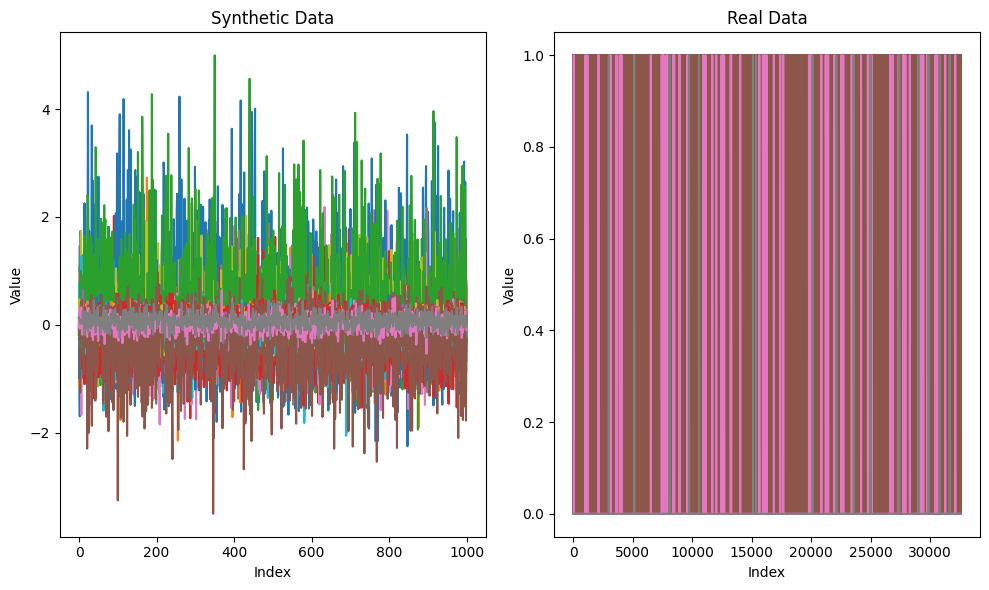

In [12]:
import matplotlib.pyplot as plt

# Assuming synthetic_data and real_data are your data
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(synthetic_data)
plt.title('Synthetic Data')
plt.xlabel('Index')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(data)
plt.title('Real Data')
plt.xlabel('Index')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming `generated_data` and `labels` are available
# generated_data: Tensor of shape (1000, 108)
# labels: Ground truth labels (binary or multi-class)

# Convert generated_data to NumPy
generated_data_np = synthetic_data

# Simulated labels for example (binary classification: 0 or 1)
# Replace this with real labels if available
labels = np.random.randint(0, 2, size=(generated_data_np.shape[0],))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(generated_data_np, labels, test_size=0.2, random_state=42)

# Train logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict on test data
y_pred = lr_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")


Logistic Regression Accuracy: 0.5150
